In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [ ]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)

group = parser.add_argument_group("model")
group.add_argument("--grid_size", type=int, default=128)
group.add_argument("--phenotype_size", type=int, default=64)
group.add_argument("--rollout_steps", type=int, default=256)

group = parser.add_argument_group("data")
group.add_argument("--n_rollout_imgs", type=int, default=4)
group.add_argument("--prompts", type=str, default="an artificial cell,a bacterium")
group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14
group.add_argument("--coef_prompts", type=float, default=1.)
group.add_argument("--coef_novelty", type=float, default=0.)

group = parser.add_argument_group("optimization")
group.add_argument("--algo", type=str, default="Sep_CMA_ES") # Sep_CMA_ES or SimAnneal or RandomSearch
group.add_argument("--bs", type=int, default=4)
group.add_argument("--pop_size", type=int, default=16)
group.add_argument("--n_iters", type=int, default=10000)
group.add_argument("--sigma", type=float, default=1.)

group.add_argument("--start_pattern", type=str, default="5N7KKM")

In [16]:
cfg_default = dict(
    seed=0, save_dir=None,
    grid_size=128, phenotype_size=64, rollout_steps=256,

    n_rollout_imgs=8,
    prompts="",

    coef_prompts=1., coef_novelty=0.,
    algo="Sep_CMA_ES",
    bs=4, pop_size=16,
    n_iters=7000,
    sigma=0.1,
    start_pattern="5N7KKM",
)

seed_sweep = np.arange(4)

prompt_sweep = [
    "a biological cell",
    "a biological cell under the microscope",
    "a red organism",
    "a bacterium under the microscope",
    "a diverse ecosystem of cells moving around",
    "an artificial life organism",
    "the lenia creature: Orbium",
    "a cool colorful pattern",
]

sigma_sweep = [0.1]

coef_novelty_sweep = [-1., -0.3, -0.1, 0., 0.1, 0.3, 1.]

cfgs = []
for seed in seed_sweep:
    for sigma in sigma_sweep:
        for coef_novelty in coef_novelty_sweep:
            for iprt, prompt in enumerate(prompt_sweep):
                cfg = cfg_default.copy()
                cfg.update(seed=seed, prompt=prompt, sigma=sigma, coef_novelty=coef_novelty)
                cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt3/{seed}_{iprt}_{sigma}_{coef_novelty}")
                cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

224


In [17]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_target_emergence_lenia.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_target_emergence_lenia.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt3/0_0_0.1_-1.0" --grid_size=128 --phenotype_size=64 --rollout_steps=256 --n_rollout_imgs=8 --prompts="" --coef_prompts=1.0 --coef_novelty=-1.0 --algo="Sep_CMA_ES" --bs=4 --pop_size=16 --n_iters=7000 --sigma=0.1 --start_pattern="5N7KKM" --prompt="a biological cell"                         
python train_target_emergence_lenia.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt3/0_1_0.1_-1.0" --grid_size=128 --phenotype_size=64 --rollout_steps=256 --n_rollout_imgs=8 --prompts="" --coef_prompts=1.0 --coef_novelty=-1.0 --algo="Sep_CMA_ES" --bs=4 --pop_size=16 --n_iters=7000 --sigma=0.1 --start_pattern="5N7KKM" --prompt="a biological cell under the microscope"    
python train_target_emergence_lenia.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/lenia_prompt3/0_2_0.1_-1.0" --grid_size=128 --phenotype_size=64 --rollout_steps=256 --n_rollout_imgs=8 --

# Visualize Results

In [18]:
import jax
import jax.numpy as jnp
import copy

In [30]:
df = []

for cfg in tqdm(cfgs):
    save_dir = cfg['save_dir']
    dfi = copy.copy(cfg)
    
    data = util.load_pkl(save_dir, "data")
    dfi['best_loss'] = data['best_loss'][-1]
    dfi.update({k: v[-500:].max(axis=-1).mean().item() for k, v in data['loss_dict'].items()})
    
    df.append(dfi)
df = pd.DataFrame(df)

  0%|          | 0/224 [00:00<?, ?it/s]

In [31]:
df

,seed,save_dir,grid_size,phenotype_size,rollout_steps,n_rollout_imgs,prompts,coef_prompts,coef_novelty,algo,bs,pop_size,n_iters,sigma,start_pattern,prompt,best_loss,loss,loss_novelty,loss_prompts
0,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,-1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a biological cell,-1.296854,-1.237358,0.988592,-0.261645
1,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,-1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a biological cell under the microscope,-1.295518,-1.259893,0.993086,-0.270287
2,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,-1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a red organism,-1.294854,-1.267716,0.990871,-0.279608
3,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,-1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a bacterium under the microscope,-1.308787,-1.234644,0.990489,-0.255334
4,0,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,-1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a diverse ecosystem of cells moving around,-1.283959,-1.255715,0.989714,-0.268387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a bacterium under the microscope,0.607930,0.678662,0.940397,-0.257010
220,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,a diverse ecosystem of cells moving around,0.586600,0.677477,0.942096,-0.259870
221,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,an artificial life organism,0.590715,0.700648,0.961121,-0.253850
222,3,/home/akarshkumar0101/nca-alife-data/lenia_pro...,128,64,256,8,,1.0,1.0,Sep_CMA_ES,4,16,7000,0.1,5N7KKM,the lenia creature: Orbium,0.600286,0.728942,0.966624,-0.236758


<Axes: xlabel='coef_novelty', ylabel='loss_prompts'>

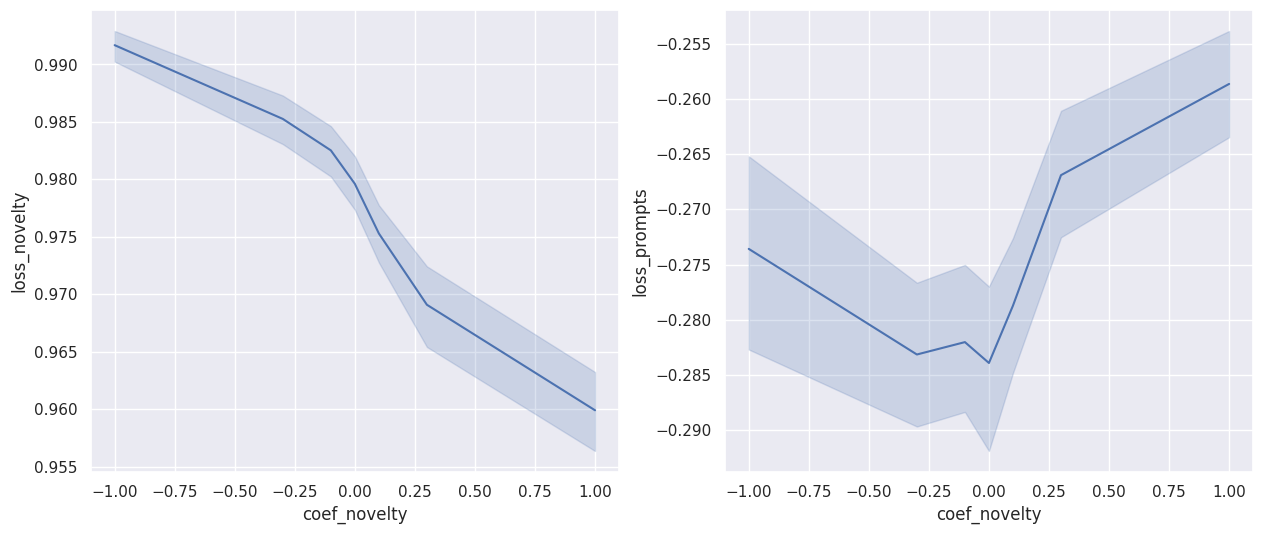

In [61]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.lineplot(data=df, x='coef_novelty', y='loss_novelty')
plt.subplot(122)
sns.lineplot(data=df, x='coef_novelty', y='loss_prompts')

  0%|          | 0/7 [00:00<?, ?it/s]

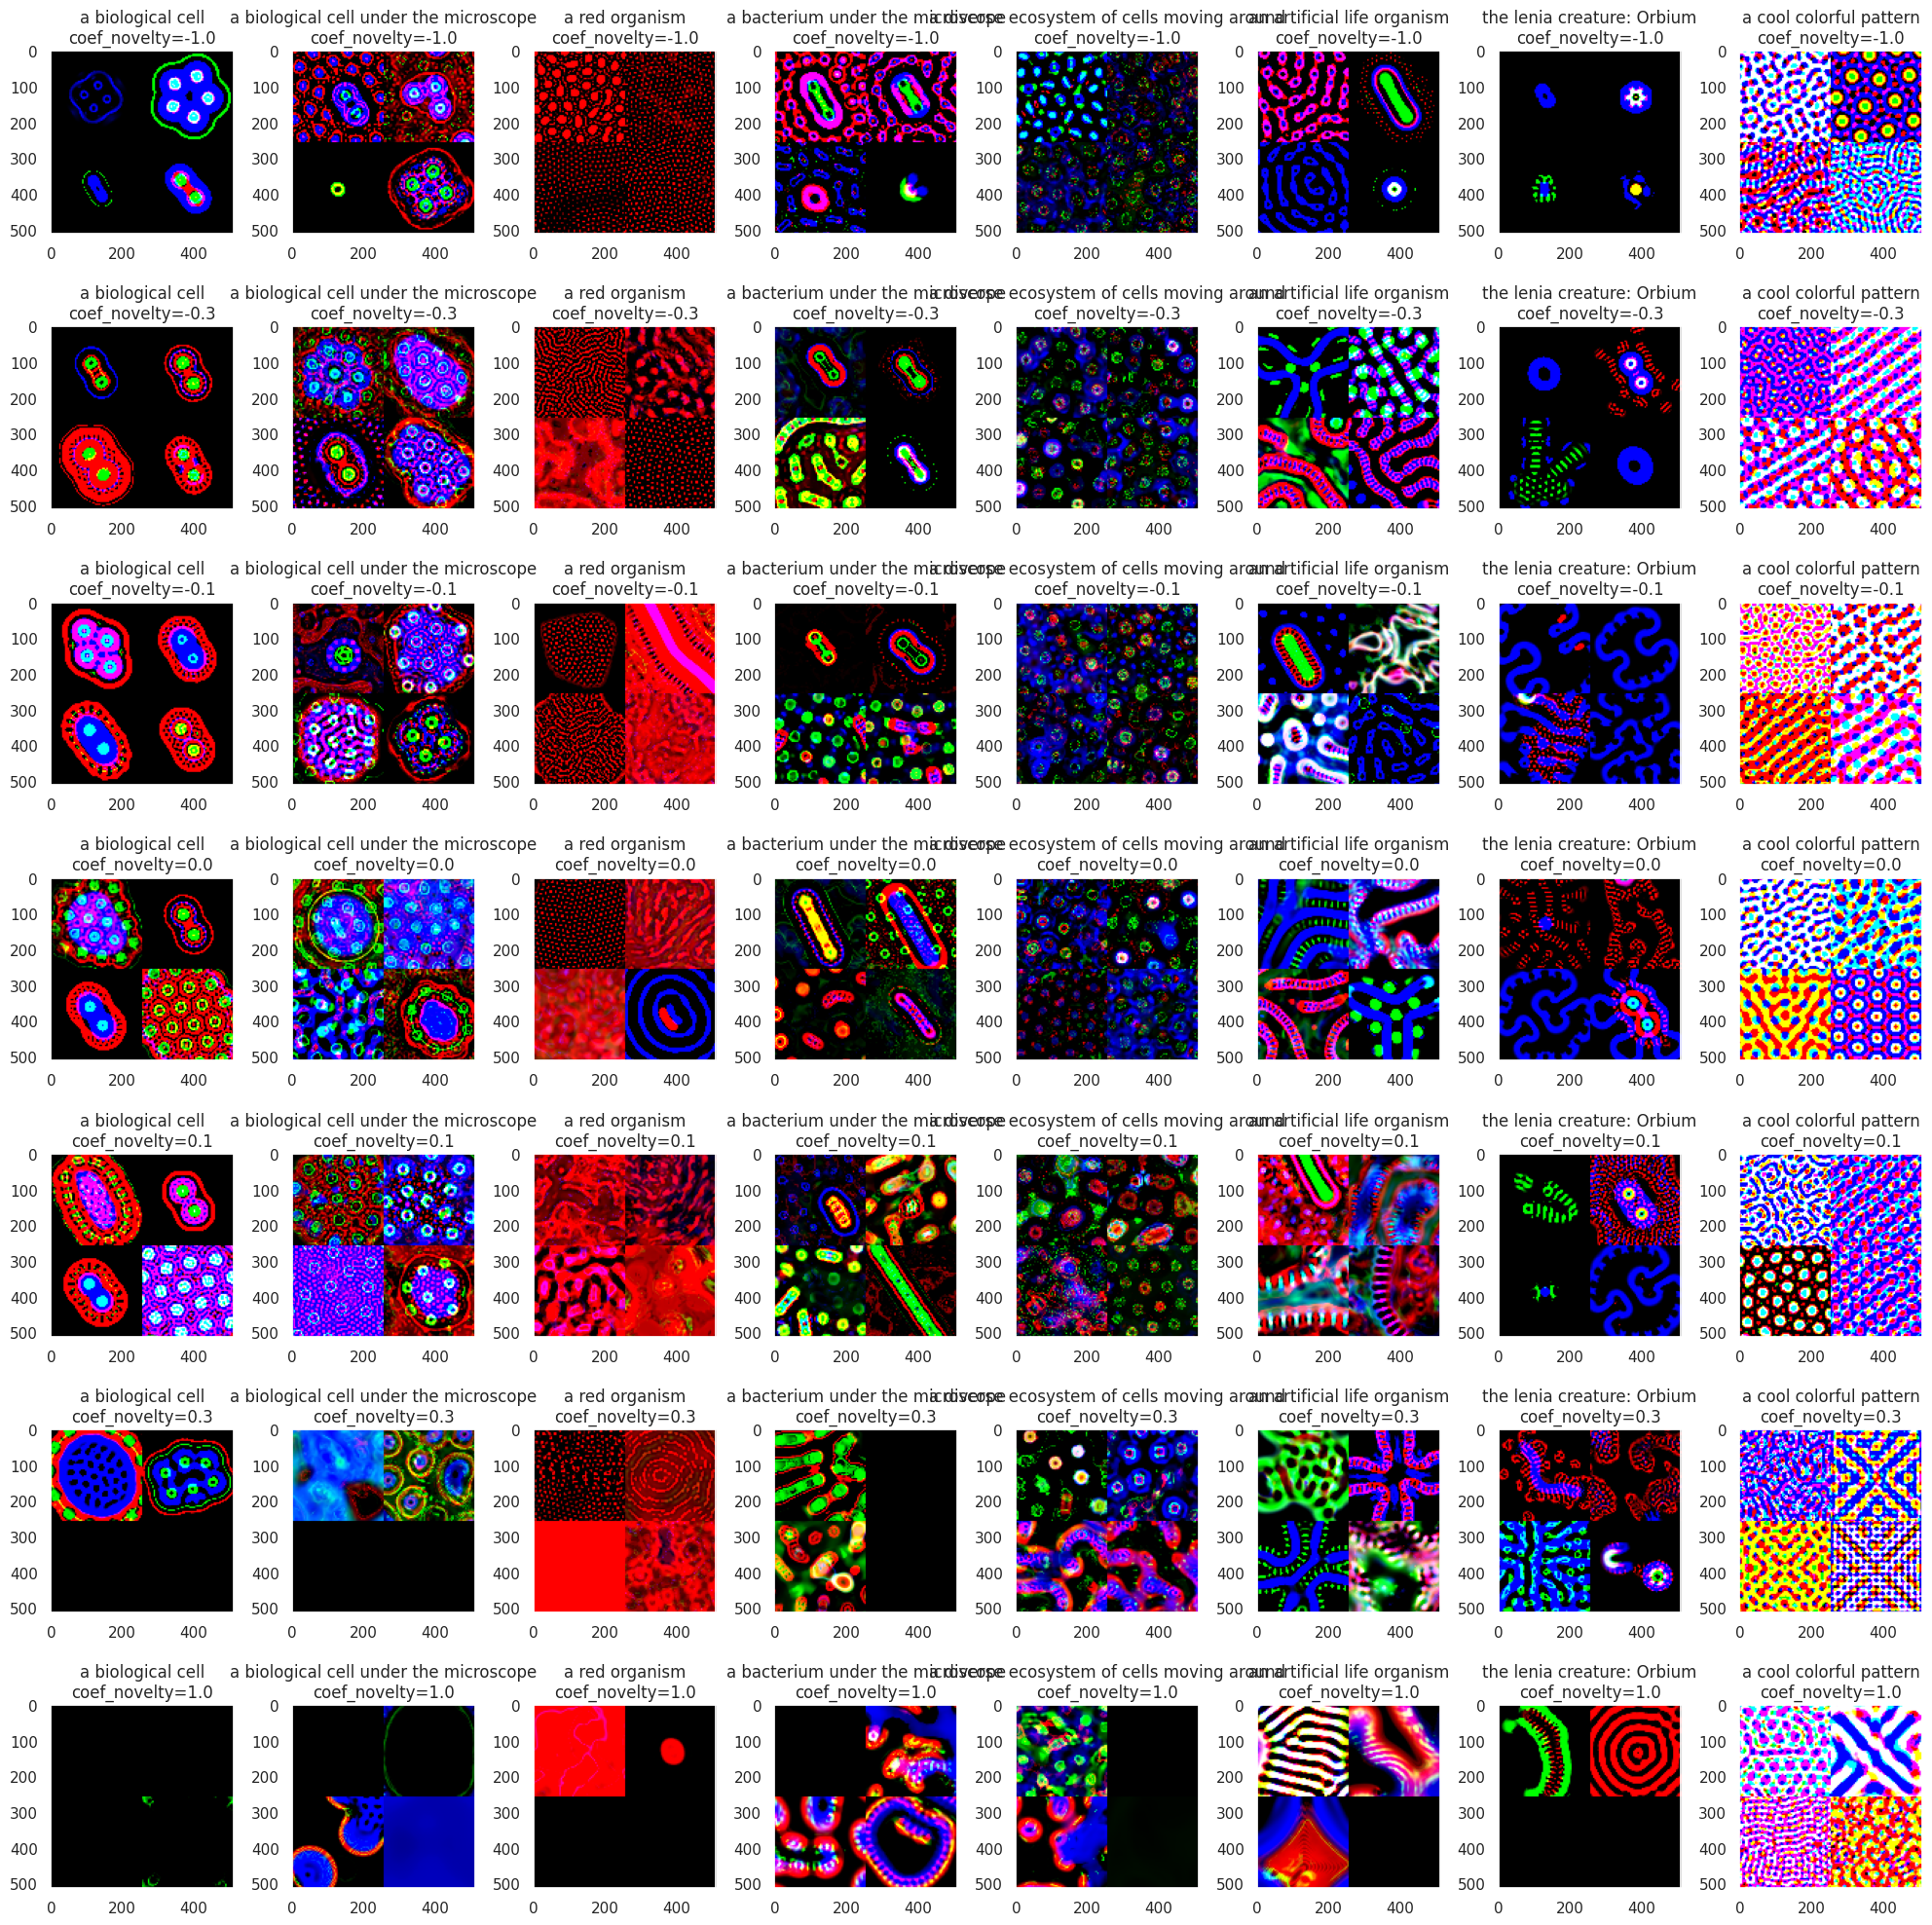

In [57]:
plt.figure(figsize=(20, 20))
iplt = 0

for sigma in sigma_sweep:
    for coef_novelty in tqdm(coef_novelty_sweep):
        for iprt, prompt in enumerate(prompt_sweep):
            imgs = []
            for seed in seed_sweep:
                save_dir=f"/home/akarshkumar0101/nca-alife-data/lenia_prompt3/{seed}_{iprt}_{sigma}_{coef_novelty}"
                img = util.load_pkl(save_dir, 'vid').astype(np.uint8)[255]
                imgs.append(img)
            imgs = rearrange(np.stack(imgs), "(R C) H W D -> (R H) (C W) D", R=2)
            iplt += 1
            plt.subplot(7, 8, iplt)
            plt.imshow(imgs)
            plt.grid(False)
            plt.title(f"{prompt}\n{coef_novelty=}")
plt.tight_layout()
plt.show()